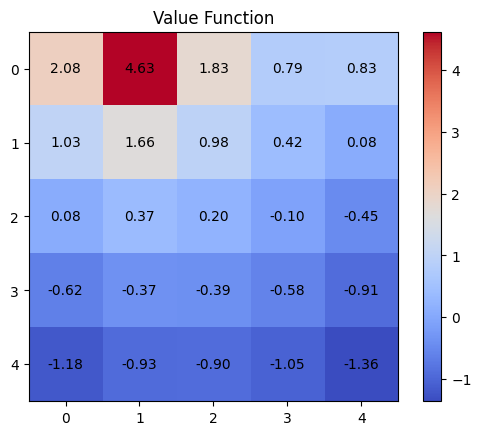

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Gridworld dimensions
grid_size = 5  # Grid size is 5x5
n_states = grid_size * grid_size # Total number of states in the grid
gamma = 0.95 # Discount factor for future rewards

# Mapping actions: up, down, left, right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
action_prob = 0.25  # # Probability of taking any action (uniform policy)

# Special states (row, col): index = row * grid_size + col
blue = (0, 1)
green = (0, 4)
red = (3, 2)
yellow = (4, 4)

# Convert to state index
def to_index(row, col):
    return row * grid_size + col

blue_idx = to_index(*blue)
green_idx = to_index(*green)
red_idx = to_index(*red)
yellow_idx = to_index(*yellow)

# Transition and reward model
def step(state, action):
    row, col = divmod(state, grid_size) # Convert state index to (row, col)
    new_row, new_col = row + action[0], col + action[1] # Compute new position
# If current state is blue, jumping to red with reward 5
    if (row, col) == blue:
        return red_idx, 5
    elif (row, col) == green:
        # Random jump to yellow or red with 0.5 prob
        return [(red_idx, 2.5 * 0.5), (yellow_idx, 2.5 * 0.5)]
    elif 0 <= new_row < grid_size and 0 <= new_col < grid_size: # If the move stays within the grid, return new state and zero reward
        return to_index(new_row, new_col), 0
    else:
        return state, -0.5 # If hitting the wall (outside grid), stay in same state with negative reward

# -------------------------------
# 1. Solve Bellman equations directly
# -------------------------------
P = np.zeros((n_states, n_states)) # Initialize matrix A for Bellman equations
R = np.zeros(n_states) # Initialize vector b for Bellman equations
# Build transition matrix and reward vector
for s in range(n_states):
    r_total = 0 # Total expected reward for state s
    for a in actions:
        result = step(s, a) # Take action a from state s
        if isinstance(result, list): # If result is a list, we have stochastic transitions (e.g., green state)
            for s_, r in result: # Add probability for each possible outcome
                P[s, s_] += action_prob * 1.0  # split prob into P
                r_total += action_prob * r # Add expected reward
        else:
            s_, r = result
            P[s, s_] += action_prob # Deterministic transition
            r_total += action_prob * r # Add expected reward
    R[s] = r_total # Store total expected reward for state s

# Solve V = R + γPV => (I - γP)V = R
I = np.eye(n_states) # Identity matrix
V_exact = np.linalg.solve(I - gamma * P, R) # Solve linear system to get exact V

# Reshape for visualization
V_exact_grid = V_exact.reshape((grid_size, grid_size))


# -------------------------------
# Visualization
# -------------------------------
def plot_values(V, title):
    fig, ax = plt.subplots()
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest') # Plot value grid
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            ax.text(j, i, f"{V[i, j]:.2f}", ha='center', va='center', color='black')
    plt.title(title)  # Set plot title
    plt.colorbar(im) # Add color bar
    plt.show() # Display plot
# Plot the value function
plot_values(V_exact_grid, "Value Function")


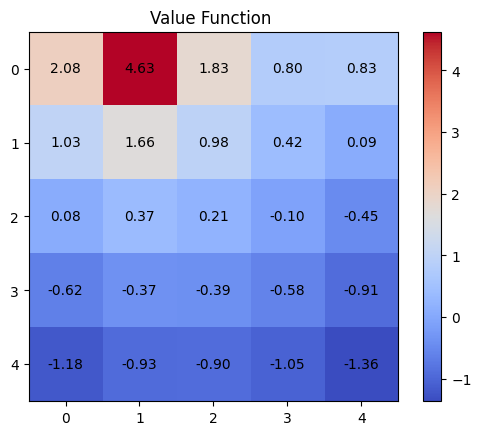

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Gridworld dimensions
grid_size = 5  # Grid size is 5x5
n_states = grid_size * grid_size # Total number of states in the grid
gamma = 0.95 # Discount factor for future rewards

# Mapping actions: up, down, left, right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
action_prob = 0.25  # # Probability of taking any action (uniform policy)

# Special states (row, col): index = row * grid_size + col
blue = (0, 1)
green = (0, 4)
red = (3, 2)
yellow = (4, 4)

# Convert to state index
def to_index(row, col):
    return row * grid_size + col

blue_idx = to_index(*blue)
green_idx = to_index(*green)
red_idx = to_index(*red)
yellow_idx = to_index(*yellow)

# Transition and reward model
def step(state, action):
    row, col = divmod(state, grid_size) # Convert state index to (row, col)
    new_row, new_col = row + action[0], col + action[1] # Compute new position
# If current state is blue, jumping to red with reward 5
    if (row, col) == blue:
        return red_idx, 5
    elif (row, col) == green:
        # Random jump to yellow or red with 0.5 prob
        return [(red_idx, 2.5 * 0.5), (yellow_idx, 2.5 * 0.5)]
    elif 0 <= new_row < grid_size and 0 <= new_col < grid_size: # If the move stays within the grid, return new state and zero reward
        return to_index(new_row, new_col), 0
    else:
        return state, -0.5 # If hitting the wall (outside grid), stay in same state with negative reward

# 2. Iterative Policy Evaluation
# Function to estimate the value function iteratively under a uniform random policy
# -------------------------------
def iterative_policy_evaluation(threshold=1e-4, max_iter=1000):
    V = np.zeros(n_states) # Initialize value function for all states to 0
    for i in range(max_iter): # Loop up to max iterations
        delta = 0 # To track the maximum change in value function
        V_new = np.zeros_like(V) # Store updated value function
        for s in range(n_states):
            v = 0 # Expected value from state s under the current policy
            for a in actions: # For each possible action
                result = step(s, a) # Take action from state s
                if isinstance(result, list):
                    v += action_prob * sum([r + gamma * V[s_] for s_, r in result]) # Handle stochastic transitions
                else:
                    s_, r = result
                    v += action_prob * (r + gamma * V[s_]) # Expected value of taking action a
            V_new[s] = v # Store new value
            delta = max(delta, abs(V[s] - V_new[s])) # Track the largest change
        V = V_new # Update the value function
        if delta < threshold: # Stop if the change is below threshold (convergence)
            break
    return V.reshape((grid_size, grid_size)) # Return value function reshaped as grid

V_iterative = iterative_policy_evaluation()
# -------------------------------
# Visualization
# Function to visualize value function as a heatmap
# -------------------------------
def plot_values(V, title):
    fig, ax = plt.subplots()
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            ax.text(j, i, f"{V[i, j]:.2f}", ha='center', va='center', color='black')
    plt.title(title)
    plt.colorbar(im)
    plt.show()

plot_values(V_iterative, "Value Function ")

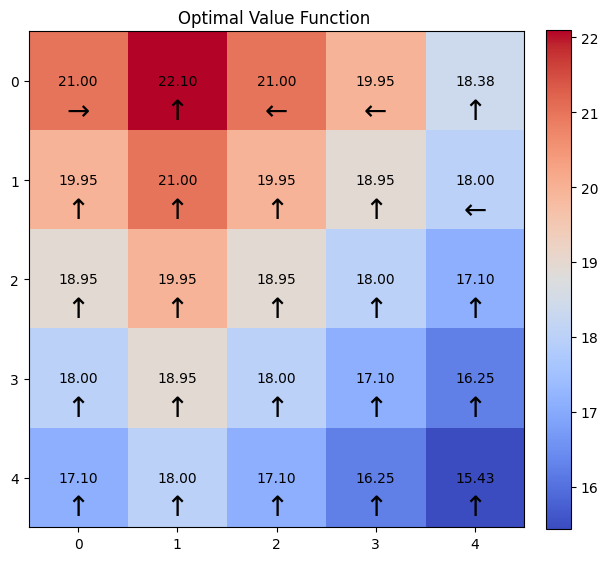

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Environment Setup
grid_size = 5               # Grid is 5x5 cells
n_states = grid_size * grid_size  # Total number of states (25)
gamma = 0.95                # Discount factor for future rewards
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right movements

# Define special states with coordinates (row, col)
blue = (0, 1)
green = (0, 4)
red = (3, 2)
yellow = (4, 4)

def to_index(row, col):

    return row * grid_size + col #Convert 2D grid coordinates to 1D state index

# Precompute indices of special states for efficiency
blue_idx = to_index(*blue)
green_idx = to_index(*green)
red_idx = to_index(*red)
yellow_idx = to_index(*yellow)

def step(state, action):
    row, col = divmod(state, grid_size)           # Convert state index to (row, col)
    new_row, new_col = row + action[0], col + action[1]  # Proposed new position

    if (row, col) == blue:
        return red_idx, 5                         # Blue state: teleport to red with reward 5
    elif (row, col) == green:
        # Green state: probabilistically teleport to red or yellow, equal chance
        return [(red_idx, 2.5), (yellow_idx, 2.5)]
    elif 0 <= new_row < grid_size and 0 <= new_col < grid_size:
        # Valid move within grid: new state, zero reward
        return to_index(new_row, new_col), 0
    else:
        # Invalid move (off grid): stay in same state with penalty
        return state, -0.5

def bellman(threshold=1e-4, max_iter=1000):
    V = np.zeros(n_states)               # Initialize value function to zeros
    policy = np.zeros(n_states, dtype=int)  # Initialize policy arbitrarily (indices to actions)

    for _ in range(max_iter):
        delta = 0                       # Track max value change this iteration
        for s in range(n_states):       # For every state
            action_values = []          # List to store value for each possible action
            for i, a in enumerate(actions):  # For each action
                result = step(s, a)           # Get next state(s) and reward(s)
                if isinstance(result, list):
                    # For stochastic outcomes, average over possible next states
                    value = np.mean([r + gamma * V[s_] for s_, r in result])
                else:
                    s_, r = result
                    value = r + gamma * V[s_]  # Bellman update: reward + discounted future value
                action_values.append(value)
            max_value = max(action_values)      # Best value among all actions
            delta = max(delta, abs(V[s] - max_value))  # Track max change
            V[s] = max_value                    # Update value function
            policy[s] = np.argmax(action_values)  # Choose action that maximizes value
        if delta < threshold:                    # Check convergence
            break

    # Reshape results into 2D grid format before returning
    return V.reshape((grid_size, grid_size)), policy.reshape((grid_size, grid_size))

def plot_value_and_policy(V, policy, title):
    arrows = ['↑', '↓', '←', '→']
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([str(i) for i in range(grid_size)])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels([str(i) for i in range(grid_size)])
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, f"{V[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)
            arrow = arrows[policy[i, j]]
            ax.text(j, i + 0.3, arrow, ha='center', va='center', color='black', fontsize=20)

    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()


# Run Bellman solver and visualize results
V_star, policy_star = bellman()                             # Compute optimal value & policy
plot_value_and_policy(V_star, policy_star, "Optimal Value Function ")


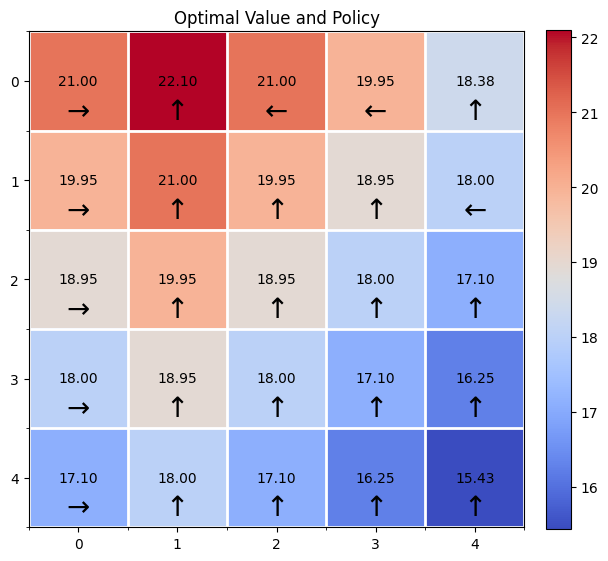

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Environment Setup
grid_size = 5                     # Grid is 5x5 cells
n_states = grid_size * grid_size  # Total number of states = 25
gamma = 0.95                     # Discount factor for future rewards
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right
n_actions = len(actions)          # Number of possible actions = 4

# Define special states (row, col)
blue = (0, 1)
green = (0, 4)
red = (3, 2)
yellow = (4, 4)

def to_index(row, col):
    return row * grid_size + col # Convert (row, col) grid coordinates to 1D state index.
blue_idx = to_index(*blue)
green_idx = to_index(*green)
red_idx = to_index(*red)
yellow_idx = to_index(*yellow)

def step(state, action):
    row, col = divmod(state, grid_size)  # Convert state index to (row, col)
    new_row, new_col = row + action[0], col + action[1]  # Calculate intended new position

    if (row, col) == blue:
        # Blue state: teleport to red with reward 5
        return red_idx, 5
    elif (row, col) == green:
        # Green state: probabilistic teleport to red or yellow with equal chance and reward 2.5
        return [(red_idx, 2.5), (yellow_idx, 2.5)]
    elif 0 <= new_row < grid_size and 0 <= new_col < grid_size:
        # Valid move inside grid: return new state with zero reward
        return to_index(new_row, new_col), 0
    else:
        # Invalid move (off grid): stay in same state with penalty -0.5
        return state, -0.5

def policy_evaluation(policy, threshold=1e-4, max_iter=1000):
    V = np.zeros(n_states)  # Initialize value function to zero for all states

    for _ in range(max_iter):
        delta = 0  # Track max change in value function for convergence
        for s in range(n_states):
            a = policy[s]              # Get action prescribed by current policy for state s
            result = step(s, actions[a])  # Get next state(s) and reward(s) for that action

            if isinstance(result, list):
                # If stochastic, average over outcomes (reward + discounted next value)
                value = np.mean([r + gamma * V[s_] for s_, r in result])
            else:
                s_, r = result
                value = r + gamma * V[s_]  # Bellman expectation update

            delta = max(delta, abs(V[s] - value))  # Track max update difference
            V[s] = value  # Update value function

        if delta < threshold:
            break  # Stop if values have converged

    return V  # Return estimated value function for the policy

def policy_improvement(V, policy):
    policy_stable = True               # Track if policy changes
    new_policy = np.zeros(n_states, dtype=int)  # Create new policy array

    for s in range(n_states):
        action_values = []             # Store value for each action at state s
        for a, act in enumerate(actions):
            result = step(s, act)     # Get next state(s) and reward(s)

            if isinstance(result, list):
                # Average over stochastic outcomes
                value = np.mean([r + gamma * V[s_] for s_, r in result])
            else:
                s_, r = result
                value = r + gamma * V[s_]

            action_values.append(value)

        best_action = np.argmax(action_values)  # Choose action with highest expected value
        new_policy[s] = best_action

        # Check if policy changed for state s
        if best_action != policy[s]:
            policy_stable = False

    return new_policy, policy_stable

def policy_iteration():
    policy = np.zeros(n_states, dtype=int)  # Start with all 'up' actions (0)

    iteration = 0
    while True:
        iteration += 1
        V = policy_evaluation(policy)         # Evaluate current policy's value function
        policy, stable = policy_improvement(V, policy)  # Improve policy greedily

        if stable:                           # If no changes, policy is optimal
            break

    return V.reshape((grid_size, grid_size)), policy.reshape((grid_size, grid_size))
def plot_value_and_policy(V, policy, title):
    arrows = ['↑', '↓', '←', '→']
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([str(i) for i in range(grid_size)])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels([str(i) for i in range(grid_size)])
    ax.set_xticks(np.arange(-0.5, grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid_size, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, f"{V[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)
            arrow = arrows[policy[i, j]]
            ax.text(j, i + 0.3, arrow, ha='center', va='center', color='black', fontsize=20)


    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()



# Run policy iteration and visualize optimal policy and value function
V_optimal, policy_optimal = policy_iteration()
plot_value_and_policy(V_optimal, policy_optimal, "Optimal Value and Policy")


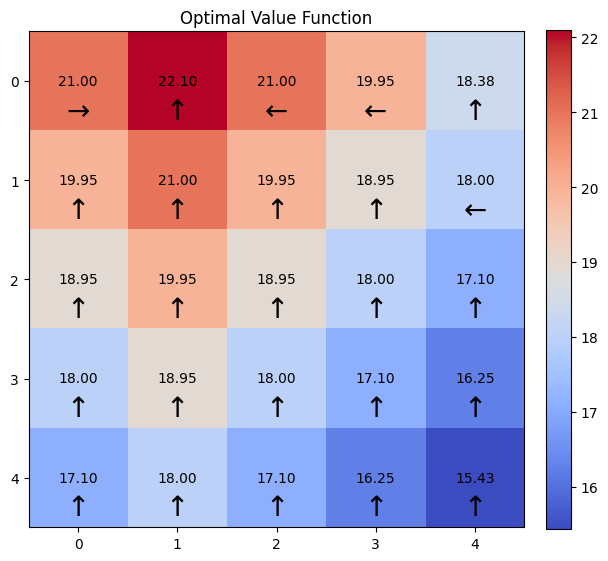

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Environment Setup
grid_size = 5
n_states = grid_size * grid_size
gamma = 0.95
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right

# Special states
blue = (0, 1)
green = (0, 4)
red = (3, 2)
yellow = (4, 4)

def to_index(row, col):
    return row * grid_size + col

blue_idx = to_index(*blue)
green_idx = to_index(*green)
red_idx = to_index(*red)
yellow_idx = to_index(*yellow)

def step(state, action):
    row, col = divmod(state, grid_size)
    new_row, new_col = row + action[0], col + action[1]

    if (row, col) == blue:
        return red_idx, 5
    elif (row, col) == green:
        return [(red_idx, 2.5), (yellow_idx, 2.5)]
    elif 0 <= new_row < grid_size and 0 <= new_col < grid_size:
        return to_index(new_row, new_col), 0
    else:
        return state, -0.5

def value_iteration(threshold=1e-4, max_iter=1000):
    """
    Perform value iteration which combines policy evaluation and improvement.
    Returns optimal value function and policy.
    """
    V = np.zeros(n_states)               # Initialize value function to zero
    policy = np.zeros(n_states, dtype=int)  # Initialize policy array

    for _ in range(max_iter):
        delta = 0
        for s in range(n_states):
            action_values = []
            for i, a in enumerate(actions):
                result = step(s, a)
                if isinstance(result, list):
                    # Average over stochastic outcomes
                    value = np.mean([r + gamma * V[s_] for s_, r in result])
                else:
                    s_, r = result
                    value = r + gamma * V[s_]
                action_values.append(value)

            max_value = max(action_values)        # Max over actions
            best_action = np.argmax(action_values)  # Greedy policy

            delta = max(delta, abs(V[s] - max_value))  # Track max change
            V[s] = max_value                      # Update value
            policy[s] = best_action               # Update policy

        if delta < threshold:
            break  # Converged

    return V.reshape((grid_size, grid_size)), policy.reshape((grid_size, grid_size))

def plot_value_and_policy(V, policy, title):
    arrows = ['↑', '↓', '←', '→']
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([str(i) for i in range(grid_size)])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels([str(i) for i in range(grid_size)])
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    for i in range(grid_size):
        for j in range(grid_size):
            ax.text(j, i, f"{V[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)
            arrow = arrows[policy[i, j]]
            ax.text(j, i + 0.3, arrow, ha='center', va='center', color='black', fontsize=20)

    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.show()


# Run value iteration and visualize
V_opt, policy_opt = value_iteration()
plot_value_and_policy(V_opt, policy_opt, "Optimal Value Function")
